# Data Analysis: SOGIE Same-Sex-Marriage

### Importing of necessary packages

In [736]:
import pandas as pd 
import numpy as np
import openpyxl 
import re

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter

import matplotlib.pyplot as plt 
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Converting Dataset to Pandas Dataframe

In [737]:
raw_dataset = 'Dataset - Group 54 - Combined.xlsx' # excel file 
df = pd.read_excel(raw_dataset) 

### Sample tweets from the dataset

In [738]:
df.head(5)

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Likes,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
0,54-1,2023-03-27 11:17:00,https://twitter.com/ReightWingAngel/status/160...,54.0,"Dycaico, Julian",GNDR,Sogie; same-sex marriage,#NoToSOGIE,@ReightWingAngel,ReiCon,...,0,0,0,0,163,False,"What is gender reassignment | Equality, Divers...",NaN,NaN,NaN
1,54-2,2023-03-27 11:48:00,https://twitter.com/ReightWingAngel/status/160...,54.0,"Dycaico, Julian",GNDR,Sogie; same-sex marriage,#NoToSOGIE,@ReightWingAngel,ReiCon,...,0,0,0,0,undefined,NaN,NaN,NaN,NaN,NaN
2,54-3,2023-03-27 12:08:00,https://twitter.com/JPAbecillaPH/status/133475...,54.0,"Dycaico, Julian",GNDR,Sogie; same-sex marriage,#NoToSOGIE,@JPAbecillaPH,JP Abecilla,...,4,0,2,2,undefined,False,Sexuality explained - Better Health Channel,NaN,NaN,NaN
3,54-4,2023-03-27 12:17:00,https://twitter.com/Conservative_PH/status/133...,54.0,"Dycaico, Julian",GNDR,Sogie; same-sex marriage,#NoToSOGIE,@Conservative_PH,Conservative Philippines,...,10,3,5,5,undefined,MISLEADING,"Genes cannot predict a person's sexuality, hom...",NaN,NaN,NaN
4,54-5,2023-03-27 21:22:00,https://twitter.com/JPAbecillaPH/status/133449...,54.0,"Dycaico, Julian",GNDR,Sogie; same-sex marriage,#noToSOGIE,@JPAbecillaPH,JP Abecilla,...,2,1,6,0,undefined,UNPROVEN,"Baseless claim that Christians are ""complacent...",NaN,NaN,NaN


## General Overview of the Data

#### Size and columns

The dataset contains 131 tweets and 30 features (Excluding 2 columns for reviewing).

In [739]:
# Size/Shape of the dataset
print(f"Dataset size: {df.shape}\n")

# Columns in the dataset
print(f"Number of columns: {df.shape[1]}\n")

# Data type of each column
print(f"Columns and their type of data:\n\n{df.dtypes}\n")

Dataset size: (131, 32)

Number of columns: 32

Columns and their type of data:

ID                          object
Timestamp           datetime64[ns]
Tweet URL                   object
Group                      float64
Collector                   object
Category                    object
Topic                       object
Keywords                    object
Account handle              object
Account name                object
Account bio                 object
Account type                object
Joined                      object
Following                    int64
Followers                    int64
Location                    object
Tweet                       object
Tweet Translated            object
Tweet Type                  object
Date posted                 object
Screenshot                  object
Content type                object
Likes                        int64
Replies                      int64
Retweets                     int64
Quote Tweets                 int64
Views    

#### Missing Values

The features with the most missing values are: **Remarks, Screenshot, Views, Location, and Account Bio.**

In [740]:
null_data = df.isnull().sum().sort_values(ascending=False)
print(f"Missing Values:\n\n{null_data[null_data>0]}")

Missing Values:

Review          131
Reviewer        131
Remarks         130
Screenshot      128
Views           107
Location         50
Account bio      26
Rating           17
Reasoning        16
Content type      9
Tweet Type        2
Account type      1
Timestamp         1
Group             1
dtype: int64


#### Dropping of Empty Columns

Drop the "Review" and "Reviewer" Columns, assign it to df_clean.
df_clean will be used from here on.

In [741]:
df_clean = df.dropna(axis=1, how='all')

print(f"Shape of df_clean: {df_clean.shape}")
print(f"Features of df_clean: {df_clean.columns.tolist()}")

Shape of df_clean: (131, 30)
Features of df_clean: ['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category', 'Topic', 'Keywords', 'Account handle', 'Account name', 'Account bio', 'Account type', 'Joined', 'Following', 'Followers', 'Location', 'Tweet', 'Tweet Translated', 'Tweet Type', 'Date posted', 'Screenshot', 'Content type', 'Likes', 'Replies', 'Retweets', 'Quote Tweets', 'Views', 'Rating', 'Reasoning', 'Remarks']


#### Distribution of Data

In [742]:
round(df_clean.describe(),2)

,Timestamp,Group,Following,Followers,Likes,Replies,Retweets,Quote Tweets
count,130,130.0,131.00,131.00,131.00,131.00,131.00,131.00
mean,2023-04-08 18:13:37.242815232,54.0,242.08,402.47,2.31,1.08,0.70,2.23
min,2023-03-27 10:49:00,54.0,0.00,0.00,0.00,0.00,0.00,0.00
25%,2023-03-31 15:55:59.151000064,54.0,42.00,10.00,0.00,0.00,0.00,0.00
50%,2023-04-03 09:56:58.216999936,54.0,102.00,31.00,0.00,0.00,0.00,0.00
75%,2023-04-19 23:45:53.592999936,54.0,284.50,189.50,2.00,0.00,0.00,0.00
max,2023-05-09 23:07:53,54.0,3294.00,18267.00,61.00,93.00,25.00,233.00
std,NaN,0.0,400.91,1754.23,6.83,8.15,2.66,20.38


#### Unique Values for Each Column

In [743]:
df_clean.nunique()

ID                  131
Timestamp            88
Tweet URL           124
Group                 1
Collector             4
Category              2
Topic                 1
Keywords             11
Account handle       81
Account name         76
Account bio          62
Account type          3
Joined               81
Following            70
Followers            64
Location             22
Tweet               125
Tweet Translated    125
Tweet Type           20
Date posted         129
Screenshot            3
Content type          3
Likes                14
Replies               8
Retweets             11
Quote Tweets          9
Views                 2
Rating               14
Reasoning            79
Remarks               1
dtype: int64

## Context-specific Questions

The main topic used for collection of data is **Sogie; same-sex marriage**

We now observe the content of the tweets. Focus on the **Tweet** column by assigning it to dfc_tweets.

In [744]:
dfc_tweets = df_clean['Tweet']
dfc_tweets.head(5)

0    Do you remember when you joined Twitter? I do!...
1    youtube.com/watch?v=vGNgESz7e30 #NoToSogieBill...
2    Sexuality is not based on feelings. It is unli...
3    Born "Gay"? "We are born this way" and "God cr...
4    Many Christians are complacent about the #SOGI...
Name: Tweet, dtype: object

Similarly to observe the **content of the bio** of the twitter accounts, we assign the **Account bio** column to dfc_bio.

In [745]:
dfc_bio = df_clean['Account bio'].astype(str).fillna(' ')
dfc_bio.head(5)


0                lady / master Noah Supporter and ALLY
1                lady / master Noah Supporter and ALLY
2    Blog of the Year 2020 (2nd Place) | #FilipinoI...
3    #ConservativePH aims to preserve traditional F...
4    Blog of the Year 2020 (2nd Place) | #FilipinoI...
Name: Account bio, dtype: object

Before counting the common words from the tweets and bios, first a bit of cleanup.

In [746]:
# Remove @user
def remove_users(tweet):
    pattern1 = "@ [\w]*"
    pattern2 = "@[\w]*"
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

# Remove links
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

# Remove Hashtags
def remove_hashtags(tweet):
    pattern1 = "# [\w]*"
    pattern2 = "#[\w]*"
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet


dfc_tweets = np.vectorize(remove_users)(dfc_tweets)
dfc_tweets = np.vectorize(remove_hashtags)(dfc_tweets)
dfc_tweets = np.vectorize(remove_links)(dfc_tweets)
# dfc_tweets = dfc_tweets.str.replace("[^a-zA-Z#]", " ")

dfc_bio = np.vectorize(remove_links)(dfc_bio)

#### Function for counting common words

In [747]:
# Define stop words 
stop_words_eng = list(stopwords.words('english'))

# From https://github.com/stopwords-iso/stopwords-tl
stop_words_fil = ['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 
'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 
'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin', 'sarili', 'sila', 'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang']

# Keywords used in Searching
stop_words_additional = ['notosogiebill', 'sogie', 'bill', 'sogie', 'notosogie', 'junksogiebill', 'amp', 'nan']

stop_words = stop_words_eng + stop_words_fil + stop_words_additional

# Initialize Count Vectorizer with defined stop words
vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word') 

def count_words(dfc_type):
    # Prepare text data 
    text = ' '.join(dfc_type)
    
    word_counts = vectorizer.fit_transform([text]).toarray().flatten()
    features = vectorizer.get_feature_names_out()

    # Create a dictionary, word - count
    word_count_dict = dict(zip(features, word_counts))
    return sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)

def print_count(dfc_type):
    for word, count in dfc_type:
        print(f"{word}: {count}")

def split_df(dfc_type):
    words = []
    for sentence in dfc_type:
        words.extend(sentence.split())
    return words

def remove_stop_words(words):
    return [word for word in words if word.lower() not in stop_words]


Common Words from Tweets

In [748]:
dfc_tweets_count = count_words(dfc_tweets)
print_count(dfc_tweets_count)

tweet_words = split_df(list(dfc_tweets))
tweet_words = remove_stop_words(tweet_words)


god: 22
equality: 20
rights: 15
anti: 14
bills: 14
law: 14
people: 14
discrimination: 11
po: 11
satanic: 11
love: 10
yes: 10
lgbt: 9
man: 9
right: 9
special: 9
act: 8
already: 8
family: 8
future: 8
lgbtq: 8
us: 8
depraved: 7
homo: 7
com: 6
constitution: 6
gender: 6
like: 6
philippines: 6
real: 6
sinner: 6
superiority: 6
totally: 6
treatment: 6
based: 5
community: 5
everyone: 5
lang: 5
mo: 5
naman: 5
respect: 5
state: 5
still: 5
truth: 5
woman: 5
would: 5
yan: 5
agree: 4
babae: 4
bakla: 4
batas: 4
become: 4
bit: 4
born: 4
cannot: 4
christians: 4
created: 4
culture: 4
feelings: 4
freedom: 4
laws: 4
lead: 4
let: 4
marriage: 4
mean: 4
member: 4
mental: 4
need: 4
nga: 4
one: 4
protect: 4
reject: 4
separation: 4
sex: 4
sin: 4
ssm: 4
tao: 4
tayong: 4
trojan: 4
tweet: 4
want: 4
ðÿ: 4
also: 3
always: 3
baklang: 3
basic: 3
chose: 3
country: 3
cr: 3
decide: 3
discriminate: 3
dont: 3
even: 3
existence: 3
existing: 3
facebook: 3
filipino: 3
filipinos: 3
freaks: 3
gay: 3
happen: 3
hate: 3
health: 3


Common Words from Twitter Account Bio

In [749]:
dfc_bio_count = count_words(dfc_bio)
print_count(dfc_bio_count)

bio_words = split_df(list(dfc_bio))
bio_words = remove_stop_words(bio_words)


conservative: 15
ð_x009d_: 15
truth: 9
god: 8
strictly: 8
life: 7
christ: 6
love: 5
loves: 5
people: 5
ðÿ: 5
ally: 4
antifakenews: 4
antifixart: 4
antihyprocrite: 4
antistupidity: 4
antiwokes: 4
biblical: 4
blackwashingcharacterisracist: 4
calvinistic: 4
charismatic: 4
christian: 4
evangelical: 4
feminismisantiwoman: 4
friend: 4
king: 4
lady: 4
master: 4
prouddds: 4
stopasianhate: 4
supporter: 4
yet: 4
action: 3
aims: 3
bayan: 3
com: 3
conservatism: 3
conservativeph: 3
diyos: 3
father: 3
filipino: 3
glory: 3
jesus: 3
joy: 3
jpabecilla: 3
knowledge: 3
lab: 3
lang: 3
lord: 3
maga: 3
never: 3
preserve: 3
simple: 3
testimony: 3
traditional: 3
values: 3
wife: 3
2020: 2
2nd: 2
_x008d_ðÿœˆnoah: 2
_x008f_: 2
_x008f_â: 2
advocate: 2
alone: 2
always: 2
apostle: 2
bible: 2
big: 2
blog: 2
boys: 2
catholic: 2
cell: 2
certified: 2
child: 2
choose: 2
doulos: 2
eye: 2
faithful: 2
fear: 2
filipinoinfluencer: 2
game: 2
great: 2
husband: 2
iskomoreno: 2
katotohanan: 2
keeps: 2
krist: 2
leader: 2
let: 2
m

Most Shared Tweets 

In [750]:
top_shared_tweets = df.nlargest(10, 'Retweets')[['Tweet', 'Retweets']].set_index('Tweet')['Retweets'].to_dict()

for tweet, retweet in top_shared_tweets.items():
    print(f"Retweets: {retweet}\nTweet: {tweet}\n\n")

Retweets: 25
Tweet: The truths and facts of SOGIE Bill and why it must not be passed.
 #NoToSogieBill


Retweets: 10
Tweet: #NOTOSOGIE YES TO THE PRESERVATION OF THE FILIPINO FAMILY! facebook.com/10000028902408â€¦


Retweets: 8
Tweet: The DANGERS OF SOGIE BILL #NoToSogieBill; Image with text: "The problem with FEELINGS-BASED SEXUAL ORIENTATION is that they are CHANGEABLE, VARIABLE, MODIFIABLE, INCONSTANT. A woman who feels she is a man and lives like a man may someday revert back to being a woman or a man who is living like a man now may decide to be a woman later, etc.


Retweets: 7
Tweet: Dito palang makikita mo nang MAY MALI sa pinaglalaban nila. Superiority ang gusto hindi equality. #NoToSOGIE #NoToSogieBill Shoutout mga hashtag users #PassADBNow #YESToSOGIEBill #SOGIEEqualityNow look how discriminatory sogie itself. (c) Stanley Clyde Flores


Retweets: 6
Tweet: Many Christians are complacent about the #SOGIEBill. Perhaps because...  They don't understand it.  They are not directly

Length of Tweets 

In [751]:
dfc_tweets_lengths = df_clean['Tweet'].str.len() 

print(f"Tweet Lengths:\n\n{dfc_tweets_lengths}")

Tweet Lengths:

0      226
1      134
2      172
3      258
4      268
      ... 
126    249
127    249
128    105
129    269
130    178
Name: Tweet, Length: 131, dtype: int64


Average Length of Tweets 

In [752]:
average_tweet_length = dfc_tweets_lengths.mean()

print(f"Average Tweet Length: {average_tweet_length}")


Average Tweet Length: 180.63358778625954


## Visualisation 

Word Cloud for Tweet Content

In [753]:
# def grab_words(tuple_list):
#     string = ""
#     for item in tuple_list:
#         string += str(item[0]) + " "
#     return string

remember joined Twitter? do! RIP Pope Benedict XVI; Image: Contains text "EVER NOTICE GENDER REASSIGNMENT SURGERY OFFERS TWO GENDERS?" youtube.com/watch?v=vGNgESz7e30 IA IA sNaCopa Sexuality based feelings. unlikely God create "a woman man's body." God God order, god confusion. Born "Gay"? "We born way" "God created us way" baseless assumptions. scientific religious data prove statements. Read here: Many Christians complacent . Perhaps because... understand it. directly affected. apathetic. encourage Christian leaders lobby Congress. Christians speak it. equal , could used stepping stone towards it. Say nga "Right motives comes Right decisions. karapatan tayong magstand along right express giving power bill, nga naiiakyat, nakikita ung bunga lipunan, pag napasa pa? Rappler brainwashing readers again. quick rebuttals . Read at: Influencers bakla. basura. Pass on. Babastos ! kasi halos anti duterte anti Gobyerno baklang chaka pa. influencer daw kamo. Ewness finest. batas po nagpoprotekta

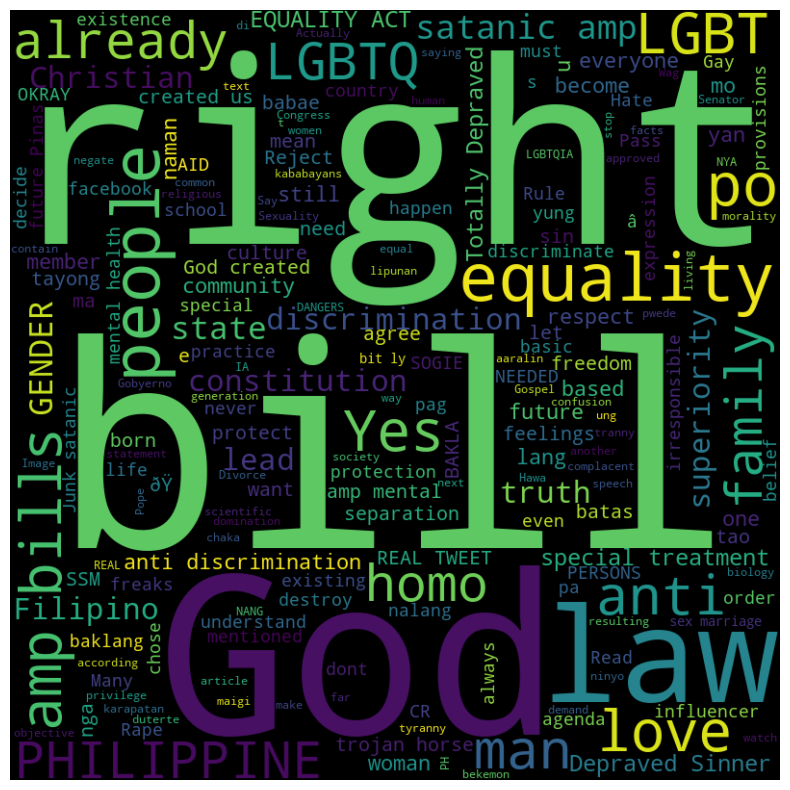

In [754]:
tweets_str =  (" ").join(tweet_words)

print(tweets_str)

wordcloud_tweets = WordCloud(width=800, height = 800).generate(tweets_str)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_tweets, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Account Bio

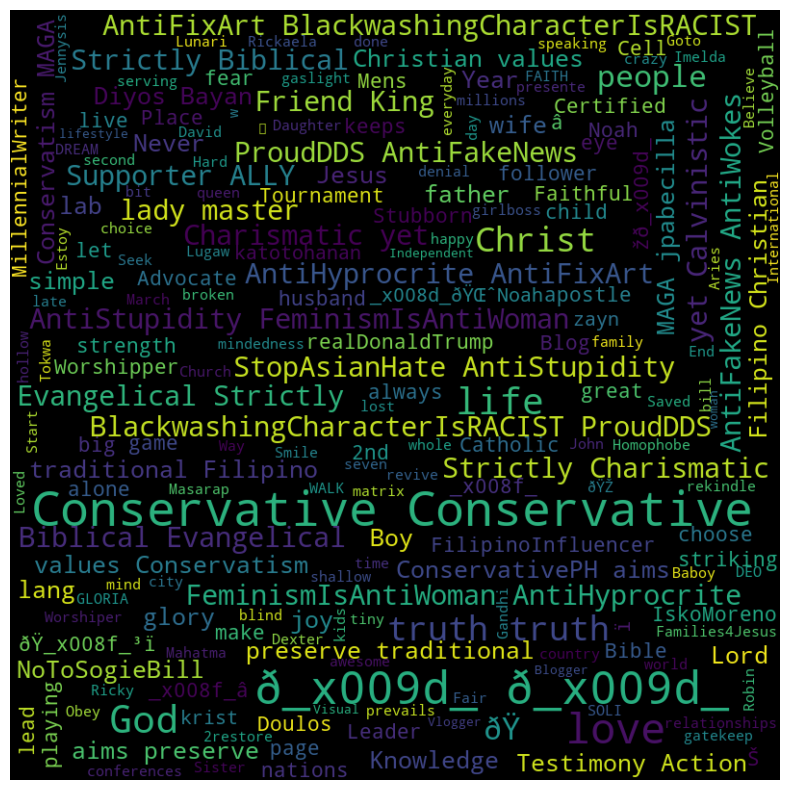

In [755]:
tweets_str =  (" ").join(bio_words)

wordcloud_tweets = WordCloud(width=800, height = 800).generate(tweets_str)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_tweets, interpolation='bilinear')
plt.axis("off")
plt.show()